In [23]:
########## FULL PIPELINE (paper-faithful) ##########
# Requirements:
#   - Seurat >= 4.1.0
#   - future, future.apply
#   - scDblFinder
#   - dplyr, stringr, Matrix
#
# Notes:
#   - QC thresholds, regressors, integration choices, clustering resolution
#     were taken from the paper (see citations in comments).
#
# Citation of parameters in the script:
#   QC thresholds: <300 or >4000 genes; percent.mt >20. :contentReference[oaicite:7]{index=7}
#   scDblFinder used to confirm doublets. :contentReference[oaicite:8]{index=8}
#   Integration: RPCA anchors; IntegrateData with normalization.method="SCT". :contentReference[oaicite:9]{index=9}
#   HVGs: 2000 (Seurat default / used by many similar pipelines). :contentReference[oaicite:10]{index=10}
#   Regression variables: nUMI, percent.mt, dissociation day, patient id, (G2M - S). :contentReference[oaicite:11]{index=11}
#   Clustering resolution: 0.4. :contentReference[oaicite:12]{index=12}
#####################################################

library(Seurat)
library(Matrix)
library(dplyr)
library(stringr)
library(future)
library(future.apply)   # for future_lapply
library(scDblFinder)    # doublet detection
# cell-cycle gene lists: Seurat provides cc.genes (if not found, supply manually)
if (!exists("cc.genes")) {
  # try to load Seurat cell-cycle lists
  if (exists("cc.genes.updated.2019")) {
    s.genes <- cc.genes.updated.2019$s.genes
    g2m.genes <- cc.genes.updated.2019$g2m.genes
  } else {
    # Fallback: small safe default lists (you can replace with full gene lists if desired)
    s.genes <- c("MCM5","PCNA","TYMS","FEN1","MCM2","MCM4","RRM1","UNG","GINS2")
    g2m.genes <- c("HMGB2","CDK1","NUSAP1","UBE2C","BIRC5","TPX2","TOP2A")
    message("Using fallback (short) cell cycle gene lists; replace with cc.genes for full scoring.")
  }
} else {
  s.genes <- cc.genes$s.genes
  g2m.genes <- cc.genes$g2m.genes
}

# ---------------------------
# User settings -- EDIT PATHS
# ---------------------------
base_dir <- "/mnt/home3/miska/nm667/scratch/inProgress/dev/data/Psoriasis_data/hanifa_data/GSE228421_count_data"
out_rds  <- "/mnt/home3/miska/nm667/scratch/inProgress/dev/data/Psoriasis_data/GSE228421_integrated_paper_faithful.rds"
# optionally supply a CSV with extra metadata (columns: sample_id, dissociation_day, any other)
extra_metadata_path <- NULL # e.g. "/path/to/extra_metadata.csv" or NULL


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQR

In [24]:

# ---------------------------
# Parallel plan
# ---------------------------
if (.Platform$OS.type == "windows") {
  plan(multisession, workers = max(1, parallel::detectCores() - 1))
} else {
  plan(multicore, workers = max(1, parallel::detectCores() - 1))
}
message("Parallel workers: ", nbrOfWorkers())

# ---------------------------
# Discover sample files (filenames -> metadata)
# ---------------------------
matrix_files <- list.files(base_dir, pattern = "matrix.mtx.gz$", full.names = TRUE)
if (length(matrix_files) == 0) stop("No matrix.mtx.gz files found in base_dir")

sample_ids <- gsub(".matrix.mtx.gz$", "", basename(matrix_files))

# metadata extractor from filenames like: GSM7120449_P1_V1_L
extract_metadata <- function(sample_name) {
  parts <- unlist(strsplit(sample_name, "_"))
  gsm_id <- parts[1]
  donor  <- parts[2]
  visit  <- parts[3]
  site_code <- parts[4]
  site <- ifelse(toupper(site_code) == "L", "lesional", "non_lesional")
  timepoint <- dplyr::case_when(
    visit == "V1" ~ "day0",
    visit == "V2" ~ "day3",
    visit == "V3" ~ "day14",
    TRUE ~ NA_character_
  )
  data.frame(sample_id = sample_name,
             gsm_id = gsm_id,
             donor = donor,
             visit = visit,
             site = site,
             timepoint = timepoint,
             stringsAsFactors = FALSE)
}

metadata_df <- do.call(rbind, lapply(sample_ids, extract_metadata))

# If user provided extra metadata CSV, merge it (useful for dissociation_day)
if (!is.null(extra_metadata_path) && file.exists(extra_metadata_path)) {
  extra_md <- read.csv(extra_metadata_path, stringsAsFactors = FALSE)
  metadata_df <- metadata_df %>% left_join(extra_md, by = "sample_id")
} else {
  # Ensure dissociation_day column exists (paper regressed it). If missing, create NA.
  if (!"dissociation_day" %in% colnames(metadata_df)) metadata_df$dissociation_day <- NA
}
metadata_df


Parallel workers: 255



sample_id,gsm_id,donor,visit,site,timepoint,dissociation_day
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
GSM7120449_P1_V1_L,GSM7120449,P1,V1,lesional,day0,NA
GSM7120450_P1_V1_NL,GSM7120450,P1,V1,non_lesional,day0,NA
GSM7120451_P1_V2_L,GSM7120451,P1,V2,lesional,day3,NA
GSM7120452_P1_V3_L,GSM7120452,P1,V3,lesional,day14,NA
GSM7120453_P2_V1_L,GSM7120453,P2,V1,lesional,day0,NA
GSM7120454_P2_V1_NL,GSM7120454,P2,V1,non_lesional,day0,NA
GSM7120455_P2_V2_L,GSM7120455,P2,V2,lesional,day3,NA
GSM7120456_P2_V3_L,GSM7120456,P2,V3,lesional,day14,NA
GSM7120457_P3_V1_L,GSM7120457,P3,V1,lesional,day0,NA


In [25]:

# ---------------------------
# Load samples in parallel (per-paper: create one Seurat per sample, QC per sample)
# QC used in paper: remove cells with <300 or >4000 unique genes, or percent.mt > 20. :contentReference[oaicite:13]{index=13}
# They also used scDblFinder to confirm doublets. :contentReference[oaicite:14]{index=14}
# ---------------------------
load_sample <- function(s) {
  mtx <- file.path(base_dir, paste0(s, ".matrix.mtx.gz"))
  bar <- file.path(base_dir, paste0(s, ".barcodes.tsv.gz"))
  feat <- file.path(base_dir, paste0(s, ".features.tsv.gz"))
  if (!file.exists(mtx) || !file.exists(bar) || !file.exists(feat)) {
    stop("Missing files for sample: ", s)
  }
  mat <- ReadMtx(mtx = mtx, features = feat, cells = bar)
  # make cell names unique with sample suffix
  colnames(mat) <- paste0(colnames(mat), "_", s)
  obj <- CreateSeuratObject(counts = mat, project = "GSE228421_raw")
  # attach metadata from metadata_df
  md <- metadata_df[metadata_df$sample_id == s, , drop = FALSE]
  obj$sample_id <- md$sample_id
  obj$gsm_id    <- md$gsm_id
  obj$donor     <- md$donor
  obj$visit     <- md$visit
  obj$site      <- md$site
  obj$timepoint <- md$timepoint
  if ("dissociation_day" %in% colnames(md)) obj$dissociation_day <- md$dissociation_day

  # compute percent.mt
  obj[["percent.mt"]] <- PercentageFeatureSet(obj, pattern = "^MT-")

  # initial QC filtering (paper thresholds).
  obj <- subset(obj, subset = nFeature_RNA > 300 & nFeature_RNA < 4000 & percent.mt < 20)

  # run scDblFinder on the raw counts matrix (scDblFinder expects SingleCellExperiment)
  # We'll run it and remove predicted doublets.
  sce <- Seurat::as.SingleCellExperiment(obj)
  sce <- scDblFinder(sce)
  # scDblFinder adds colData(sce)$scDblFinder.class
  dbl <- colData(sce)$scDblFinder.class
  names(dbl) <- colnames(sce)
  # keep only 'singlet' cells (others likely "doublet" or "doublet?"); paper used scDblFinder to confirm doublets removed.
  singlet_cells <- names(dbl)[dbl == "singlet"]
  obj <- subset(obj, cells = singlet_cells)

  # Compute cell cycle scores (S, G2M) and cell_cycle_diff = G2M - S (the paper regressed difference).
  obj <- NormalizeData(obj, verbose = FALSE) # needed prior to CellCycleScoring if counts are not lognorm - harmless
  obj <- CellCycleScoring(obj, s.features = s.genes, g2m.features = g2m.genes, set.ident = FALSE)
  # Create numeric scores
  obj$S.Score <- ifelse(is.na(obj$S.Score), 0, obj$S.Score)
  obj$G2M.Score <- ifelse(is.na(obj$G2M.Score), 0, obj$G2M.Score)
  obj$cell_cycle_diff <- obj$G2M.Score - obj$S.Score

  return(obj)
}

# run in parallel
seurat_list <- future_lapply(sample_ids, function(s) {
  message("Loading and QC sample: ", s)
  obj <- load_sample(s)
  return(obj)
})
names(seurat_list) <- sample_ids


Loading and QC sample: GSM7120449_P1_V1_L

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Layer ‘data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”
Creating ~9499 artificial doublets...

Dimensional reduction

Evaluating kNN...

Training model...

iter=0, 2317 cells excluded from training.

iter=1, 2299 cells excluded from training.

iter=2, 2259 cells excluded from training.

Threshold found:0.457

1369 (11.5%) doublets called

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”
Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be i

In [30]:

# ---------------------------
# Per-sample SCTransform (paper did SCTransform per-sample) and regression:
# Variables regressed (paper): number of unique molecular identifiers per cell, percentage of mitochondrial genes,
# day of single-cell dissociation, patient identifier, and difference between G2M and S phase score. :contentReference[oaicite:15]{index=15}
# We'll compute the list of regressors that actually exist in the object metadata and pass them to SCTransform(vars.to.regress=...)
# ---------------------------
library(future)
library(future.apply)

# ---------------------------
# SAFE PARALLEL PLAN
# ---------------------------
workers <- min(4, future::availableCores())
plan(multicore, workers = workers)   # use multisession on Windows
message("Parallel SCT workers: ", workers)

# ---------------------------
# Per-sample SCTransform
# ---------------------------
sct_per_sample <- function(obj) {

  # nCount_RNA already exists automatically in Seurat object
  # DO NOT recreate it or assign it (your old line caused failure)

  # regressors actually available
  possible_regs <- c("nCount_RNA", "percent.mt", "cell_cycle_diff")
  regs <- possible_regs[possible_regs %in% colnames(obj@meta.data)]

  message("SCTransform on sample: ", unique(obj$sample_id),
          " | Regressing: ", paste(regs, collapse = ", "))

  SCTransform(
    obj,
    vars.to.regress = regs,
    conserve.memory = TRUE,
    verbose = TRUE,
    method = "glmGamPoi"
  )
}

# ---------------------------
# Batching (4 samples at a time)
# ---------------------------
batch_size <- 5
batches <- split(sample_ids, ceiling(seq_along(sample_ids) / batch_size))

for (b in batches) {
  message("\n=== Processing batch: ", paste(b, collapse = ", "), " ===")

  seurat_list[b] <- future_lapply(
    seurat_list[b],
    sct_per_sample,
    future.seed = TRUE
  )
}

# ---------------------------
# Ensure correct naming
# ---------------------------
names(seurat_list) <- sample_ids



Parallel SCT workers: 4


=== Processing batch: GSM7120449_P1_V1_L, GSM7120450_P1_V1_NL, GSM7120451_P1_V2_L, GSM7120452_P1_V3_L ===

Warning message:
“Hmm... 1 active multicore processes were detected, but without any active multicore futures (it is not clear by what mechanism they were created). Because of this, the 'future' package do not know how to resolve/collect them and will therefore treat them as they do not exist”


  |======================================================================| 100%


SCTransform on sample: GSM7120449_P1_V1_L | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20547 by 10504

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = c

  |======================================================================| 100%


SCTransform on sample: GSM7120450_P1_V1_NL | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20687 by 7452

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = c

  |======================================================================| 100%


SCTransform on sample: GSM7120451_P1_V2_L | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21390 by 10276

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = c

  |======================================================================| 100%


SCTransform on sample: GSM7120452_P1_V3_L | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21037 by 10098

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = c

  |======================================================================| 100%


SCTransform on sample: GSM7120453_P2_V1_L | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20971 by 10298

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = c

  |======================================================================| 100%


SCTransform on sample: GSM7120454_P2_V1_NL | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21258 by 10775

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, 

  |======================================================================| 100%


SCTransform on sample: GSM7120455_P2_V2_L | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20640 by 8899

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = co

  |======================================================================| 100%


SCTransform on sample: GSM7120456_P2_V3_L | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21883 by 12412

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, m

  |======================================================================| 100%


SCTransform on sample: GSM7120457_P3_V1_L | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 19415 by 9940

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = co

  |======================================================================| 100%


SCTransform on sample: GSM7120458_P3_V1_NL | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 19163 by 10069

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in glm.nb(formula = as.formula(new_formula), data = data):
“alternation limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :


  |======================================================================| 100%


SCTransform on sample: GSM7120459_P3_V2_L | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 19841 by 6256

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, mu

  |======================================================================| 100%


SCTransform on sample: GSM7120460_P3_V3_L | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20045 by 6381

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = co

  |======================================================================| 100%


SCTransform on sample: GSM7120461_P4_V1_L | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21288 by 10104

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, m

  |======================================================================| 100%


SCTransform on sample: GSM7120462_P4_V1_NL | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21052 by 9761

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = c

  |======================================================================| 100%


SCTransform on sample: GSM7120463_P4_V2_L | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21138 by 9826

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in glm.nb(formula = as.formula(new_formula), data = data):
“alternation limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“i

  |======================================================================| 100%


SCTransform on sample: GSM7120464_P4_V3_L | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20747 by 6767

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = co

  |======================================================================| 100%


SCTransform on sample: GSM7120465_P5_V1_L | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21215 by 11228

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, m

  |======================================================================| 100%


SCTransform on sample: GSM7120466_P5_V1_NL | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20985 by 10813

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = 

  |======================================================================| 100%


SCTransform on sample: GSM7120467_P5_V2_L | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21085 by 10277

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, m

  |======================================================================| 100%


SCTransform on sample: GSM7120468_P5_V3_L | Regressing: nCount_RNA, percent.mt, cell_cycle_diff

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 21052 by 11542

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in sqrt(1/i):
“NaNs produced”
Warning message in theta.ml(Y, m

In [32]:

# ---------------------------
# Integration prep: select features (paper uses HVG = 2000) :contentReference[oaicite:16]{index=16}
# ---------------------------
hvg_n <- 2000
features <- SelectIntegrationFeatures(object.list = seurat_list, nfeatures = hvg_n)


In [34]:
seurat_list

$GSM7120449_P1_V1_L
An object of class Seurat 
57158 features across 10504 samples within 2 assays 
Active assay: SCT (20547 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA

$GSM7120450_P1_V1_NL
An object of class Seurat 
57298 features across 7452 samples within 2 assays 
Active assay: SCT (20687 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA

$GSM7120451_P1_V2_L
An object of class Seurat 
58001 features across 10276 samples within 2 assays 
Active assay: SCT (21390 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA

$GSM7120452_P1_V3_L
An object of class Seurat 
57648 features across 10098 samples within 2 assays 
Active assay: SCT (21037 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA

$GSM7120453_P2_V1_L
An object of class Seurat 
57582 features across 102

In [35]:
library(future)

# Turn off parallelization for SCT integration steps
plan(sequential)
options(future.globals.maxSize = Inf)


In [36]:

# Prep SCT integration
seurat_list <- PrepSCTIntegration(object.list = seurat_list, anchor.features = features)


In [39]:
# -------------------------------------------------------
# After PrepSCTIntegration() — RUN PCA ON EACH OBJECT
# RPCA absolutely requires this step
# -------------------------------------------------------
for (i in seq_along(seurat_list)) {
  message("Running PCA on sample: ", names(seurat_list)[i])
  seurat_list[[i]] <- RunPCA(
    seurat_list[[i]],
    features = features,
    verbose = FALSE
  )
}


Running PCA on sample: GSM7120449_P1_V1_L

Running PCA on sample: GSM7120450_P1_V1_NL

Running PCA on sample: GSM7120451_P1_V2_L

Running PCA on sample: GSM7120452_P1_V3_L

Running PCA on sample: GSM7120453_P2_V1_L

Running PCA on sample: GSM7120454_P2_V1_NL

Running PCA on sample: GSM7120455_P2_V2_L

Running PCA on sample: GSM7120456_P2_V3_L

Running PCA on sample: GSM7120457_P3_V1_L

Running PCA on sample: GSM7120458_P3_V1_NL

Running PCA on sample: GSM7120459_P3_V2_L

Running PCA on sample: GSM7120460_P3_V3_L

Running PCA on sample: GSM7120461_P4_V1_L

Running PCA on sample: GSM7120462_P4_V1_NL

Running PCA on sample: GSM7120463_P4_V2_L

Running PCA on sample: GSM7120464_P4_V3_L

Running PCA on sample: GSM7120465_P5_V1_L

Running PCA on sample: GSM7120466_P5_V1_NL

Running PCA on sample: GSM7120467_P5_V2_L

Running PCA on sample: GSM7120468_P5_V3_L



In [40]:

# ---------------------------
# Find anchors using RPCA (reciprocal PCA) per paper :contentReference[oaicite:17]{index=17}
# ---------------------------
anchors <- FindIntegrationAnchors(object.list = seurat_list,
                                  normalization.method = "SCT",
                                  anchor.features = features,
                                  reduction = "rpca")


Computing within dataset neighborhoods



Finding all pairwise anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 5000 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 12666 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 5595 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 6514 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 8761 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 8288 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 8963 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 5167 anchors

P

In [41]:

# ---------------------------
# Integrate data (normalization.method = "SCT") per paper :contentReference[oaicite:18]{index=18}
# ---------------------------
combined <- IntegrateData(anchorset = anchors, normalization.method = "SCT")

# ---------------------------
# Run PCA / UMAP / clustering exactly as paper:
# Paper used KNN graph (FindNeighbors) and FindClusters at resolution 0.4. Use dims = 1:30 for neighborhood. :contentReference[oaicite:19]{index=19}
# ---------------------------
DefaultAssay(combined) <- "integrated"
combined <- RunPCA(combined, verbose = FALSE)
combined <- RunUMAP(combined, dims = 1:30, verbose = FALSE)
combined <- FindNeighbors(combined, dims = 1:30)
combined <- FindClusters(combined, resolution = 0.4)  # paper: 0.4

# ---------------------------
# Differential expression settings from paper:
# FindAllMarkers with fold-change > 1.5 and Bonferroni adj p < 0.05. :contentReference[oaicite:20]{index=20}
# Example usage (not run by default):
# markers <- FindAllMarkers(combined, only.pos = TRUE, min.pct = 0.05, logfc.threshold = log2(1.5))
# then apply Bonferroni correction to p_val
# ---------------------------

# Save integrated Seurat object
saveRDS(combined, out_rds)
message("Saved integrated object to: ", out_rds)


[1] 1


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 2


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 3


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 4


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 5


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 6


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 7


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 8


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 9


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 10


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 11


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 12


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 13


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 14


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 15


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 16


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 17


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 18


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 19


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


[1] 20


Warning message:
“Different cells and/or features from existing assay SCT”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Merging dataset 9 into 5

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Merging dataset 10 into 6

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Merging dataset 7 into 8

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
“Layer counts isn't present in the assay object; returning NULL”
Merging dataset 11 into 15

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Wa

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 193678
Number of edges: 7420856

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9574
Number of communities: 24
Elapsed time: 98 seconds


Saved integrated object to: /mnt/home3/miska/nm667/scratch/inProgress/dev/data/Psoriasis_data/GSE228421_integrated_paper_faithful.rds



In [43]:
#str(combined)

Assays(combined)


An object of class "SimpleAssays"
Slot "data":
List of length 1


In [45]:
combined@assays$SCT


SCTAssay data with 24865 features for 193678 cells, and 20 SCTModel(s) 
First 10 features:
 AL627309.5, LINC01409, FAM87B, LINC01128, LINC00115, FAM41C, SAMD11,
NOC2L, KLHL17, PLEKHN1 

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



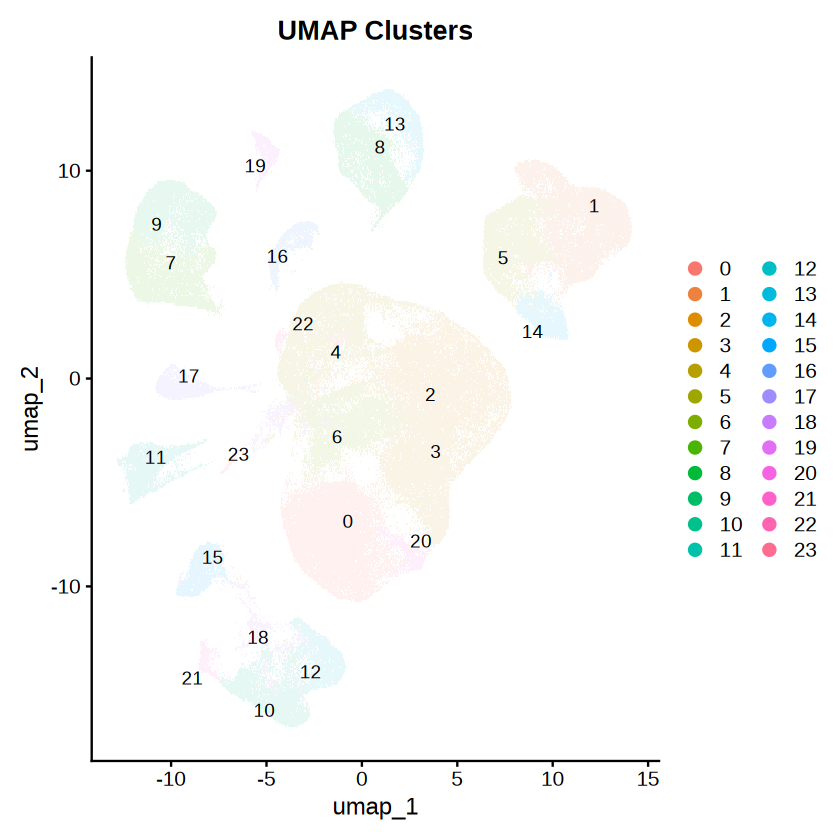

In [47]:
library(Seurat)
library(ggplot2)

# UMAP with clusters (labels)
DimPlot(combined, reduction = "umap", group.by = "seurat_clusters", 
        label = TRUE, repel = TRUE, pt.size = 0.1) +
  ggtitle("UMAP Clusters")


In [49]:
# Number of cells total
ncol(combined)

[1] 193678